# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

After installation of the ddgan package run the following line to import it

In [2]:
import ddgan
from ddgan import *

### Loading Data

In [3]:
nPOD = 5
evaluated_subdomains = 2
subdomains = 4
start_from = 400
steps = 10
dims = 3
datapoints = 1000 + steps - 1


csv_data = np.load('../data/processed/pod_coeffs_field_Velocity.npy', )

assert nPOD <= csv_data.shape[1], "Make sure the data includes enough POD coeffs"
assert datapoints + start_from <= csv_data.shape[2], "Not enough data"
assert evaluated_subdomains + 2 <= csv_data.shape[0], "Not enough domains"

In [4]:
# Cutting the dataset
csv_data = csv_data[:subdomains,:nPOD,start_from:start_from+datapoints]
csv_data.shape

(4, 5, 1009)

In [5]:
# Transposing data
tmp_data = np.ones([subdomains, datapoints, nPOD])

new_data = np.ones([subdomains, nPOD, datapoints])
for i in range(subdomains):
    for j in range(nPOD):
        for k in range(datapoints):
            new_data[i][j][k] = nPOD*j + (i + 1)*10000 + k  

for k in range(subdomains):
    #tmp_data[k] = csv_data[k].T
    tmp_data[k] = new_data[k].T
    
csv_data = tmp_data
csv_data.shape

(4, 1009, 5)

In [6]:
# Scaling
scales = []
csv_data2 = np.zeros_like(csv_data)
for i in range(subdomains):
    scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
    csv_data2[i] = scales[i].fit_transform(csv_data[i])

In [7]:
# Asserting scaling is accurate
cond = np.zeros_like(csv_data2)
for i in range(subdomains):
    cond[i] = scales[i].inverse_transform(csv_data2[i])
assert np.allclose(csv_data[0,:,0], cond[0,:,0]), "Scaling failed"  

for dim in range(subdomains):
    for icol in range(nPOD):
        assert np.isclose(np.min(csv_data2[dim][:,icol]) + np.max(csv_data2[dim][:,icol]), 0), "Scaling failed" 

In [8]:
tmp_data

array([[[10000., 10005., 10010., 10015., 10020.],
        [10001., 10006., 10011., 10016., 10021.],
        [10002., 10007., 10012., 10017., 10022.],
        ...,
        [11006., 11011., 11016., 11021., 11026.],
        [11007., 11012., 11017., 11022., 11027.],
        [11008., 11013., 11018., 11023., 11028.]],

       [[20000., 20005., 20010., 20015., 20020.],
        [20001., 20006., 20011., 20016., 20021.],
        [20002., 20007., 20012., 20017., 20022.],
        ...,
        [21006., 21011., 21016., 21021., 21026.],
        [21007., 21012., 21017., 21022., 21027.],
        [21008., 21013., 21018., 21023., 21028.]],

       [[30000., 30005., 30010., 30015., 30020.],
        [30001., 30006., 30011., 30016., 30021.],
        [30002., 30007., 30012., 30017., 30022.],
        ...,
        [31006., 31011., 31016., 31021., 31026.],
        [31007., 31012., 31017., 31022., 31027.],
        [31008., 31013., 31018., 31023., 31028.]],

       [[40000., 40005., 40010., 40015., 40020.],
     

In [9]:
# new_data = np.ones([subdomains, nPOD, datapoints])
# for i in range(subdomains):
#     for j in range(nPOD):
#             new_data[i][j] = nPOD*j + i  

In [10]:
# Setting up the data into subdomains 
# 2 x nTrain x nsteps * nPOD *3 # 'float32' or np.float32
t_begin = 0
t_end = datapoints-steps + 1

training_data = np.zeros((evaluated_subdomains, t_end, nPOD * steps * dims), dtype=np.float32) 

for domain in range(evaluated_subdomains): 
    for i, dim in enumerate([0,2,1]):
        for step in range(steps):
            training_data[domain, :, steps*nPOD*i + step*nPOD : steps*nPOD*i + (step+1)*nPOD] = tmp_data[dim + domain][t_begin+step : t_end+step, :]

# Adding data for leftmost and rightmost domain
boundrary_conditions = []
boundrary_conditions.append(tmp_data[0, steps-1:])
boundrary_conditions.append(tmp_data[-1, steps-1:])

In [11]:
boundrary_conditions

[array([[10009., 10014., 10019., 10024., 10029.],
        [10010., 10015., 10020., 10025., 10030.],
        [10011., 10016., 10021., 10026., 10031.],
        ...,
        [11006., 11011., 11016., 11021., 11026.],
        [11007., 11012., 11017., 11022., 11027.],
        [11008., 11013., 11018., 11023., 11028.]]),
 array([[40009., 40014., 40019., 40024., 40029.],
        [40010., 40015., 40020., 40025., 40030.],
        [40011., 40016., 40021., 40026., 40031.],
        ...,
        [41006., 41011., 41016., 41021., 41026.],
        [41007., 41012., 41017., 41022., 41027.],
        [41008., 41013., 41018., 41023., 41028.]])]

In [12]:
joined_train_data = training_data.reshape((training_data.shape[1]*training_data.shape[0], training_data.shape[2]))

print(training_data.shape)
print(joined_train_data.shape)

(2, 1000, 150)
(2000, 150)


In [13]:
tmp_data[0,steps-1:].shape

(1000, 5)

### Initializing GAN

In [14]:
kwargs = {
    "nsteps" : steps,
    "ndims" : dims * nPOD,
    "batch_size" : 100,
    "batches" : 20,
    "seed" : 143,
    "epochs" : 35000,
    "n_critic" : 10,
    "gen_learning_rate" : 5e-4,
    "disc_learning_rate" : 5e-4,
}

gan = GAN(**kwargs)
gan.setup()
set_seed(gan.seed)
assert gan.nsteps*gan.ndims*gan.batch_size*gan.batches - joined_train_data.shape[0]*joined_train_data.shape[1] == 0, "Check inputs and data"

ndims_latent_input = gan.ndims
joined_train_data = np.float32(joined_train_data)
print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(joined_train_data), joined_train_data.shape, joined_train_data.dtype)

making new generator and critic
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (2000, 150) float32


In [15]:
t0 = time.time()
#gan.learn_hypersurface_from_POD_coeffs(joined_train_data)
t_train = time.time() - t0

In [16]:
gan.generator(np.zeros([1,10]))[:,1:]

<tf.Tensor: shape=(1, 149), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [17]:
kwargs_opt = {
    "start_from" : 0,
    "nPOD" : 5,
    "nLatent" : 10,
    "npredictions" : 10,
    "optimizer_epochs" : 1,
    "gan" : gan,
    "bounds" : 1e5,
    "cycles" : 3
}

optimizer = Optimize(**kwargs_opt)
flds = optimizer.predictDD(training_data, tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)))

Time step: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
tf.Tensor(
[[[10000. 10005. 10010. 10015. 10020. 10001. 10006. 10011. 10016. 10021.
   10002. 10007. 10012. 10017. 10022. 10003. 10008. 10013. 10018. 10023.
   10004. 10009. 10014. 10019. 10024. 10005. 10010. 10015. 10020. 10025.
   10006. 10011. 10016. 10021. 10026. 10007. 10012. 10017. 10022. 10027.
   10008. 10013. 10018. 10023. 10028. 10009. 10014. 10019. 10024. 10029.
   30000. 30005. 30010. 30015. 30020. 30001. 30006. 30011. 30016. 30021.
   30002. 30007. 30012. 30017. 30022. 30003. 30008. 30013. 30018. 30023.
   30004. 30009. 30014. 30019. 30024. 30005. 30010. 30015. 30020. 30025.
   30006. 30011. 30016. 30021. 30026. 30007. 30012. 30017. 30022. 30027.
   30008. 30013. 30018. 30023. 30028. 30009. 30014. 30019. 30024. 30029.
   20000. 20005. 20010. 20015. 20020. 20001. 20006. 200

Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
[[[10004. 10009. 10014. 10019. 10024. 10005. 10010. 10015. 10020. 10025.
   10006. 10011. 10016. 10021. 10026. 10007. 10012. 10017. 10022. 10027.
   10008. 10013. 10018. 10023. 10028. 10009. 10014. 10019. 10024. 10029.
   30000. 30005. 30010. 30015. 30020. 30001. 30006. 30011. 30016. 30021.
   30002. 30007. 30012. 30017. 30022. 30003. 30008. 30013. 30018. 30023.
   30004. 30009. 30014. 30019. 30024. 30005. 30010. 30015. 30020. 30025.
   30006. 30011. 30016. 30021. 30026. 30007. 30012. 30017. 30022. 30027.
   30008. 30013. 30018. 30023. 30028. 30009. 30014. 30019. 30024. 30029.
   20000. 20005. 20010. 20015. 20020. 20001. 20006. 20011. 20016. 20021.
   20002. 20007. 20012. 20017. 20022. 20003. 20008. 20013. 20018. 20023.
   20004. 20009. 20014. 20019. 20024. 20005. 20010. 20015. 20020. 20025.
   20006. 20011. 20016. 20021

Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
Optimizer epoch: 	 0
[[[10008. 10013. 10018. 10023. 10028. 10009. 10014. 10019. 10024. 10029.
   30000. 30005. 30010. 30015. 30020. 30001. 30006. 30011. 30016. 30021.
   30002. 30007. 30012. 30017. 30022. 30003. 30008. 30013. 30018. 30023.
   30004. 30009. 30014. 30019. 30024. 30005. 30010. 30015. 30020. 30025.
   30006. 30011. 30016. 30021. 30026. 30007. 30012. 30017. 30022. 30027.
   30008. 30013. 30018. 30023. 30028. 30009. 30014. 30019. 30024. 30029.
   20000. 20005. 20010. 20015. 20020. 20001. 20006. 20011. 20016. 20021.
   20002. 20007. 20012. 20017. 20022. 20003. 20008. 20013. 20018. 20023.
   20004. 20009. 20014. 20019. 20024. 20005. 20010. 20015. 20020. 20025.
   20006. 20011. 20016. 20021. 20026. 20007. 20012. 20017. 20022. 20027.
   20008. 20013. 20018. 20023. 20028.     0.     0.     0.     0.     0.
       0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
       0.     0.   

In [18]:
flds

<tf.Tensor: shape=(2, 39, 5), dtype=float32, numpy=
array([[[10000., 10005., 10010., 10015., 10020.],
        [10001., 10006., 10011., 10016., 10021.],
        [10002., 10007., 10012., 10017., 10022.],
        [10003., 10008., 10013., 10018., 10023.],
        [10004., 10009., 10014., 10019., 10024.],
        [10005., 10010., 10015., 10020., 10025.],
        [10006., 10011., 10016., 10021., 10026.],
        [10007., 10012., 10017., 10022., 10027.],
        [10008., 10013., 10018., 10023., 10028.],
        [10009., 10014., 10019., 10024., 10029.],
        [30000., 30005., 30010., 30015., 30020.],
        [30001., 30006., 30011., 30016., 30021.],
        [30002., 30007., 30012., 30017., 30022.],
        [30003., 30008., 30013., 30018., 30023.],
        [30004., 30009., 30014., 30019., 30024.],
        [30005., 30010., 30015., 30020., 30025.],
        [30006., 30011., 30016., 30021., 30026.],
        [30007., 30012., 30017., 30022., 30027.],
        [30008., 30013., 30018., 30023., 30028.]

In [19]:
flds.shape

TensorShape([2, 39, 5])

In [20]:
tf.__version__

'2.5.0'

In [21]:
np.array(boundrary_conditions)[0,1,:]

array([10010., 10015., 10020., 10025., 10030.])

In [22]:
training_data[1][optimizer.start_from,
            :(optimizer.gan.nsteps-1)*optimizer.nPOD * 3 
            ].reshape(1, (optimizer.gan.nsteps - 1) * optimizer.nPOD* 3).shape

(1, 135)

AttributeError: 'GAN' object has no attribute 'npredictions'

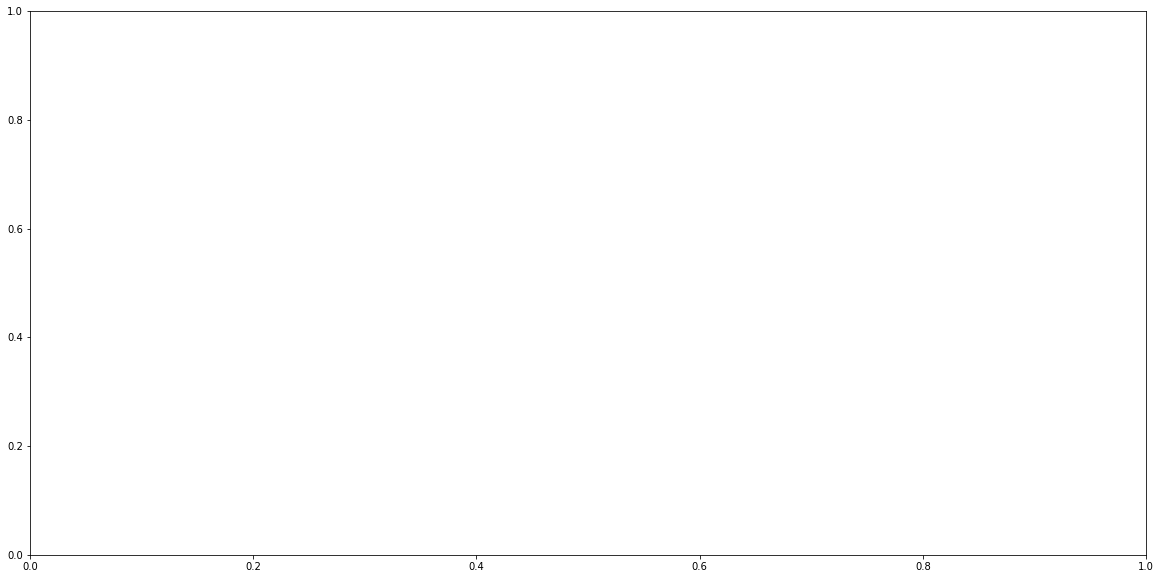

In [23]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:gan.npredictions, :])
plt.show()

fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:, :])
plt.show()

fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:gan.npredictions, :])
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(flds[-10:,:])
plt.show()

In [ ]:
np.save('../data/reconstructed/velocity_field.npy', np.reshape((basis[:,:gan.ndims] @ scaling.inverse_transform((flds)).T), [1,2,221,42,-1]))

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')


tmp_data2 = np.zeros_like(csv_data)
for i in range(subdomains):
    scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
    csv_data2[i] = scales[i].fit_transform(csv_data[i])


In [ ]:
scaling.inverse_transform(flds)

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')

In [ ]:
basis.shape

In [ ]:
a = []
for i in range(8000):
    a.append(np.max(basis[i,:]))

In [ ]:
plt.scatter(np.arange(8000),a)

In [ ]:
np.max(basis[:,1])

In [ ]:
len(boundrary_conditions[0])

In [ ]:
boundrary_conditions